In [1]:
#https://ieeexplore.ieee.org/document/10549889

In [2]:
!pip install openpyxl ssqueezepy

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from ssqueezepy import cwt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
import pywt
import matplotlib.pyplot as plt

2024-12-03 18:18:20.640243: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 18:18:20.640324: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 18:18:20.640361: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 18:18:20.648838: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import keras.models
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [5]:
# Load datasets
ppg_data_combined = pd.read_excel('combined_dataset.xlsx')

print(ppg_data_combined)

     Num.  subject_ID Sex(M/F)  Age(year)  Height(cm)  Weight(kg)  \
0       1           2   Female         45         152          63   
1       1           2   Female         45         152          63   
2       1           2   Female         45         152          63   
3       2           3   Female         50         157          50   
4       2           3   Female         50         157          50   
..    ...         ...      ...        ...         ...         ...   
652   218         418     Male         25         173          63   
653   218         418     Male         25         173          63   
654   219         419     Male         24         175          58   
655   219         419     Male         24         175          58   
656   219         419     Male         24         175          58   

     Systolic Blood Pressure(mmHg)  Diastolic Blood Pressure(mmHg)  \
0                              161                              89   
1                              

In [6]:
# 참가자의 숫자 확인
print(ppg_data_combined['subject_ID'].nunique())

219


The dataset provided by Liang et al. in their study is a valuable resource for non-invasive CVD detection, encompassing 657 data segments from 219 individuals.

In [7]:
data_systolic = ppg_data_combined["Systolic Blood Pressure(mmHg)"]
data_diastolic = ppg_data_combined["Diastolic Blood Pressure(mmHg)"]

ppg_data = ppg_data_combined.iloc[:,14:]

In [8]:
# # Initialize the MinMaxScaler
# scaler = MinMaxScaler()

# # Fit the scaler to your data
# scaler.fit(data_personal)

# # Transform the data
# normalized_data = scaler.transform(data_personal)

In [9]:
ppg_data = np.array(ppg_data)
print(ppg_data)

[[2438 2438 2438 ... 1827 1754 1754]
 [2201 2201 2171 ... 1997 1997 1997]
 [2019 2014 2014 ... 1924 1929 1929]
 ...
 [3083 3039 3071 ... 2422 2451 2379]
 [2426 2431 2446 ... 3103 3146 3151]
 [2691 2718 2743 ... 2611 2639 2623]]


In [10]:
# Assuming bp_data has columns 'systolic' and 'diastolic'
# Normalize blood pressure data
bp_data = np.array([data_systolic, data_diastolic]).T
print(bp_data)

[[161  89]
 [161  89]
 [161  89]
 ...
 [108  68]
 [108  68]
 [108  68]]


In [11]:
print(ppg_data.shape)
print(bp_data.shape)

(657, 2100)
(657, 2)


### 이상치 제거를 위한 Bandpass Filter와 Wavelet 변환

In [12]:
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# Butterworth High-pass Filter
def butter_highpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data

# Butterworth Low-pass Filter
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data

# Combined Band-pass Filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    # Step 1: Apply High-pass Filter
    highpass_filtered = butter_highpass_filter(data, lowcut, fs, order)
    # Step 2: Apply Low-pass Filter
    bandpass_filtered = butter_lowpass_filter(highpass_filtered, highcut, fs, order)
    return bandpass_filtered


In [13]:
# Sampling frequency (Hz)
fs = 1000  # PPG 데이터의 샘플링 주파수
lowcut = 0.5  # 고역 통과 필터의 낮은 차단 주파수 (Hz)
highcut = 15.0  # 저역 통과 필터의 높은 차단 주파수 (Hz)

# Apply Band-pass Filter
ppg_bandpassed = butter_bandpass_filter(ppg_data, lowcut, highcut, fs)

# Print shape to verify
print("Shape after band-pass filtering:", ppg_bandpassed.shape)


Shape after band-pass filtering: (657, 2100)


### 원본 PPG와 잡음 제거 후 PPG 시각화

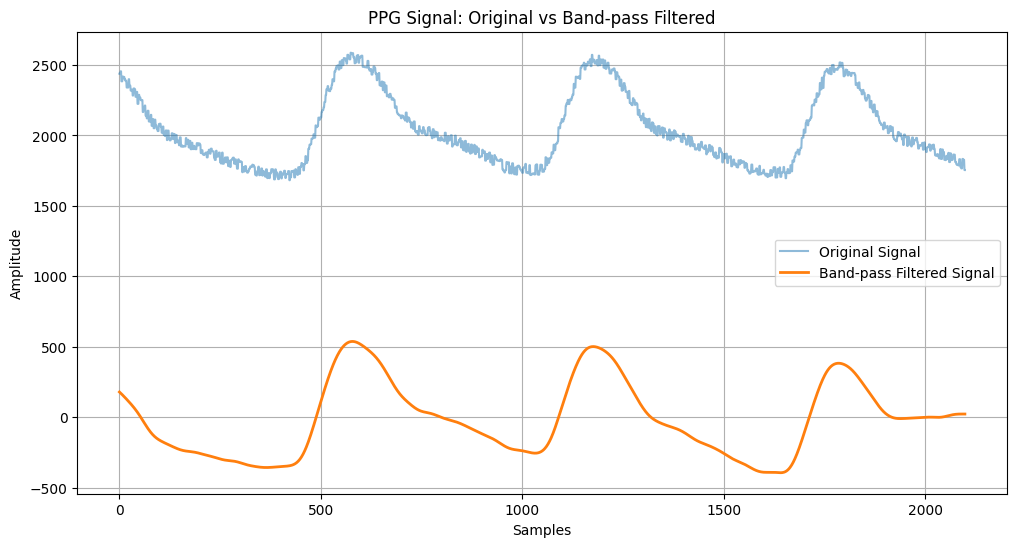

In [14]:
# Visualize a single PPG signal before and after filtering
plt.figure(figsize=(12, 6))
plt.plot(ppg_data[0], label="Original Signal", alpha=0.5)
plt.plot(ppg_bandpassed[0], label="Band-pass Filtered Signal", linewidth=2)
plt.legend()
plt.title("PPG Signal: Original vs Band-pass Filtered")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

In [15]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(ppg_bandpassed, bp_data, test_size=0.2, random_state=42)

print("Train/Test Split:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Train/Test Split:
X_train shape: (525, 2100), y_train shape: (525, 2)
X_test shape: (132, 2100), y_test shape: (132, 2)


In [16]:
# # Function to create sliding window data for LSTM
# def create_sequence_data(X, y, time_steps=200, step=40):
#     Xs, ys = [], []
#     for i in range(0, len(X) - time_steps, step):
#         Xs.append(X[i:i + time_steps])
#         ys.append(y[i + time_steps - 1])  # Use the last value in the window as the label
#     return np.array(Xs), np.array(ys)

# TIME_STEPS = 10  # Decrease to allow sliding windows in test set
# STEP = 5         # Small step size to maximize number of windows

# # Create LSTM-compatible data
# X_train_lstm, y_train_lstm = create_sequence_data(X_train, y_train, TIME_STEPS, STEP)
# X_test_lstm, y_test_lstm = create_sequence_data(X_test, y_test, TIME_STEPS, STEP)

# print("LSTM Data Shapes with Adjusted Parameters:")
# print(f"X_train_lstm: {X_train_lstm.shape}, y_train_lstm: {y_train_lstm.shape}")
# print(f"X_test_lstm: {X_test_lstm.shape}, y_test_lstm: {y_test_lstm.shape}")

In [17]:
# PPG Signal (2100, 1)으로 변환
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train_lstm = y_train
y_test_lstm = y_test

In [18]:
def CWT_transform(data):
    images = []
    for signal in data:
        Wx, _ = cwt(signal, wavelet='morlet')  # Perform CWT
        Wx = np.abs(Wx)
        Wx = (Wx - Wx.min()) / (Wx.max() - Wx.min())  # Normalize
        images.append(Wx)

    # Ensure all samples have the same shape and convert to numpy array
    images = np.array(images)
    print(f"Shape of transformed data: {images.shape}")
    return images

# Perform CWT transform
X_train_cwt = CWT_transform(X_train)
X_test_cwt = CWT_transform(X_test)

# Add a channel dimension to make the data 3D (height, width, channels)
X_train_cwt = np.array([img[..., np.newaxis] for img in X_train_cwt])  # (246, 2100, 1)
X_test_cwt = np.array([img[..., np.newaxis] for img in X_test_cwt])    # (246, 2100, 1)

# Resize to (128, 128) for CNN input
X_train_cwt = np.array([tf.image.resize(img, [128, 128]).numpy() for img in X_train_cwt])
X_test_cwt = np.array([tf.image.resize(img, [128, 128]).numpy() for img in X_test_cwt])

# Ensure data shape is (samples, 128, 128, 1)
# Do NOT add an extra channel dimension here
print("Final CNN Data Shapes:")
print(f"X_train_cwt: {X_train_cwt.shape}, X_test_cwt: {X_test_cwt.shape}")

/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Shape of transformed data: (525, 246, 2100)
Shape of transformed data: (132, 246, 2100)


2024-12-03 18:19:29.930509: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:0b:00.0, compute capability: 8.0
2024-12-03 18:19:29.932873: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:48:00.0, compute capability: 8.0


Final CNN Data Shapes:
X_train_cwt: (525, 128, 128, 1), X_test_cwt: (132, 128, 128, 1)


In [21]:
# Slice CNN data to match LSTM samples
X_train_cwt = X_train_cwt[:X_train_lstm.shape[0]]
X_test_cwt = X_test_cwt[:X_test_lstm.shape[0]]

# Debug final shapes
print("After Slicing:")
print(f"X_train_cwt shape: {X_train_cwt.shape}, X_train_lstm shape: {X_train_lstm.shape}")
print(f"y_train_lstm shape: {y_train_lstm.shape}")

After Slicing:
X_train_cwt shape: (525, 128, 128, 1), X_train_lstm shape: (525, 2100, 1)
y_train_lstm shape: (525, 2)


In [22]:
# # LSTM model for sequence data
# def create_lstm_model(input_shape):
#     model = Sequential([
#         layers.Input(shape=input_shape),
#         layers.LSTM(32, return_sequences=True),
#         layers.Dropout(0.3),
#         layers.LSTM(64, return_sequences=True),
#         layers.Dropout(0.3),
#         layers.LSTM(128, return_sequences=True),
#         layers.Dropout(0.3),
#         layers.LSTM(128),
#         layers.Dropout(0.3),
#         layers.Dense(128, activation='relu')
#     ])
#     return model

In [23]:
# Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Network
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [24]:
# Transformer Branch 수정
def build_transformer_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.3,
    mlp_dropout=0.3,
):
    # 입력 이름을 명시적으로 설정
    inputs = keras.Input(shape=input_shape, name="Transformer_Input")
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    return inputs, x

In [25]:
# Combined CNN + Transformer Model
def build_combined_model(
    cnn_input_shape,
    transformer_input_shape,
    transformer_params,
    mlp_units,
    output_dim=2,  # For SBP and DBP
    dropout=0.25,
):
    # CNN Branch
    cnn_inputs = keras.Input(shape=cnn_input_shape, name="CNN_Input")
    x = layers.Conv2D(32, (3, 3), activation="relu")(cnn_inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    cnn_outputs = layers.Dense(128, activation="relu")(x)

    # Transformer Branch
    transformer_inputs, transformer_outputs = build_transformer_model(
        transformer_input_shape, **transformer_params, mlp_units=mlp_units
    )

    # Combine CNN and Transformer
    combined = layers.concatenate([cnn_outputs, transformer_outputs])
    x = layers.Dense(128, activation="relu")(combined)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(output_dim, activation="linear", name="BP_Output")(x)

    # Build and compile model
    model = Model(inputs=[cnn_inputs, transformer_inputs], outputs=outputs)
    return model

In [26]:
# Transformer Parameters
transformer_params = {
    "head_size": 64,
    "num_heads": 4,
    "ff_dim": 128,
    "num_transformer_blocks": 3,
    "dropout": 0.25,
    "mlp_dropout": 0.4,
}

# Input shapes
cnn_input_shape = (128, 128, 1)  # CNN input for CWT images
transformer_input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])  # Transformer input for LSTM-like sequence

# Build model
model = build_combined_model(
    cnn_input_shape,
    transformer_input_shape,
    transformer_params,
    mlp_units=[128],
    output_dim=2,  # For SBP and DBP
    dropout=0.25,
)

# Compile the model
model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["mse"]
)

# Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Transformer_Input (InputLa  [(None, 2100, 1)]            0         []                            
 yer)                                                                                             
                                                                                                  
 multi_head_attention (Mult  (None, 2100, 1)              1793      ['Transformer_Input[0][0]',   
 iHeadAttention)                                                     'Transformer_Input[0][0]']   
                                                                                                  
 dropout (Dropout)           (None, 2100, 1)              0         ['multi_head_attention[0][0]']
                                                                                              

                                                                                                  
 dropout_5 (Dropout)         (None, 2100, 128)            0         ['conv1d_4[0][0]']            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0]']       
                                                                                                  
 conv1d_5 (Conv1D)           (None, 2100, 1)              129       ['dropout_5[0][0]']           
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)           0         ['conv2d_1[0][0]']            
 g2D)                                                                                             
                                                                                                  
 layer_nor

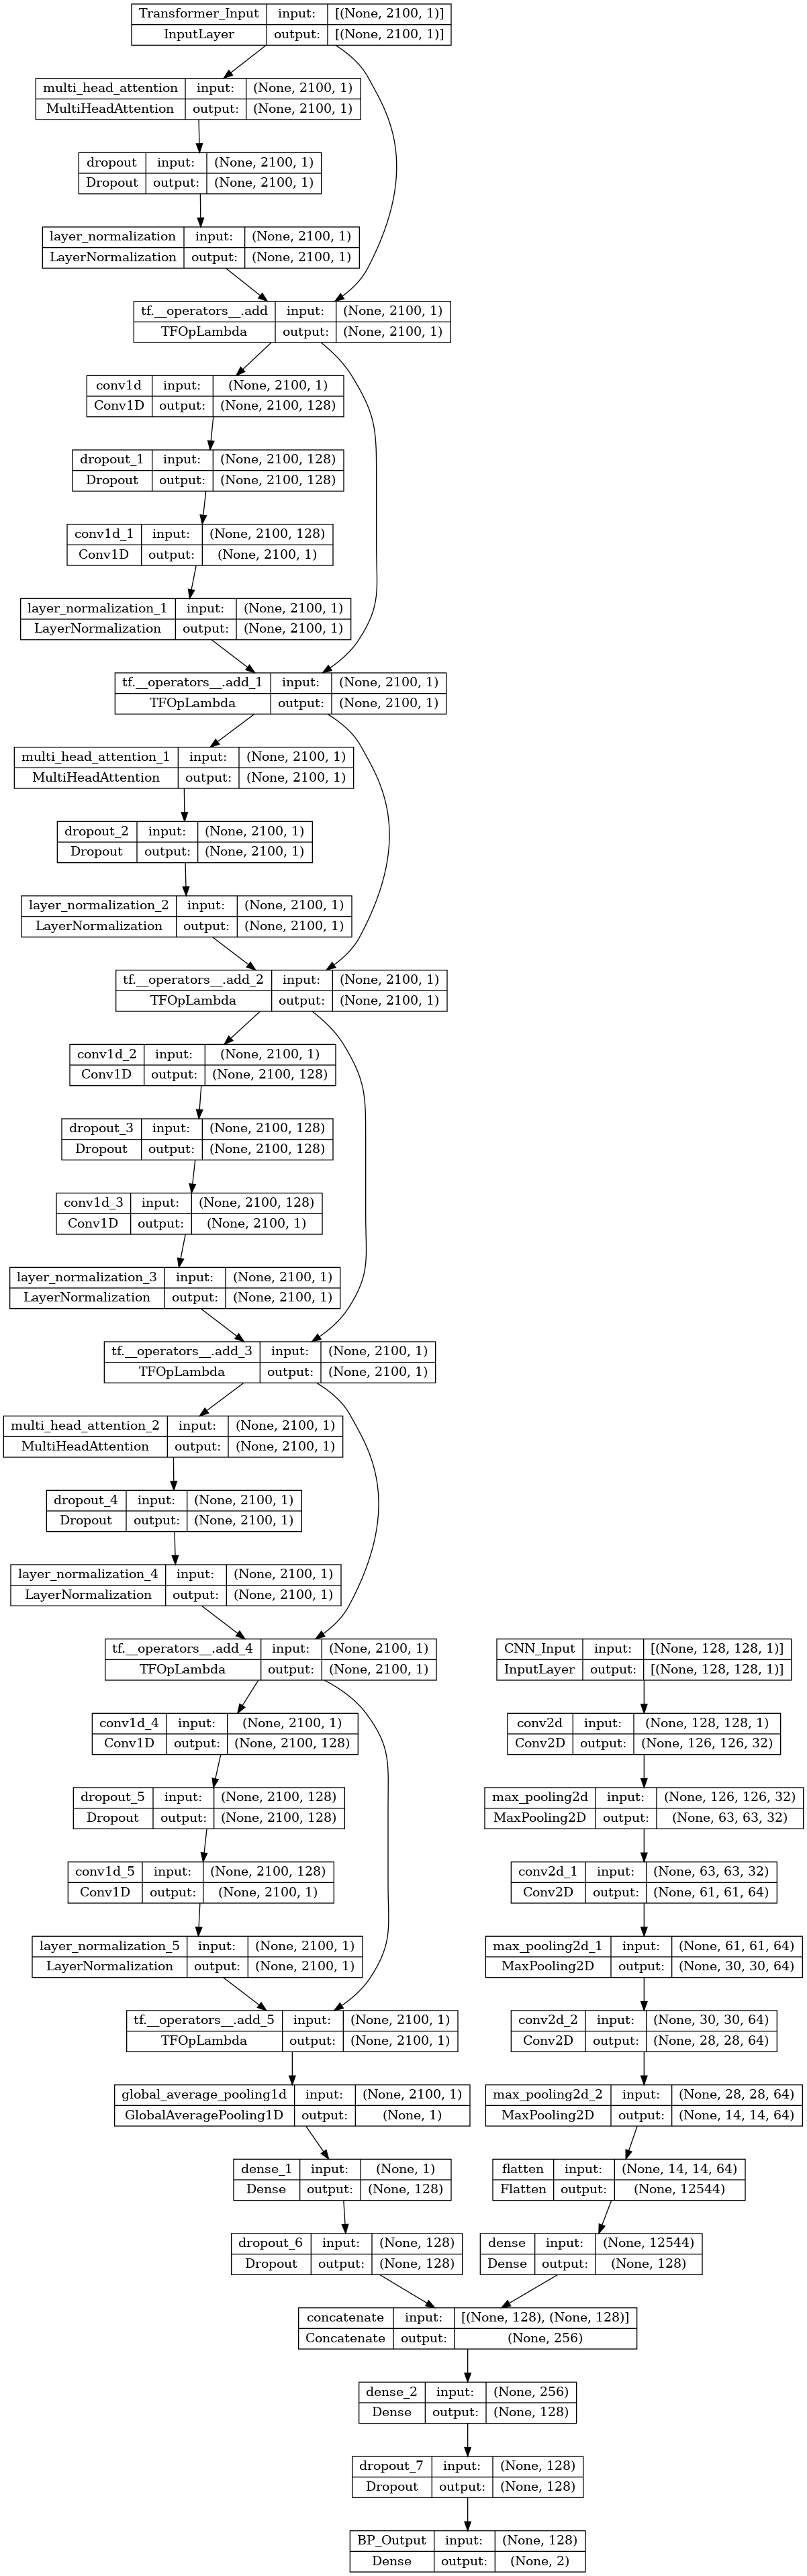

In [27]:
from tensorflow.keras.utils import plot_model

# 모델 시각화
plot_model(
    model,                   # 학습에 사용된 모델
    to_file="model_plot.png",  # 저장할 파일 이름
    show_shapes=True,         # 각 레이어의 출력 텐서 모양 표시
    show_layer_names=True,    # 레이어 이름 표시
    expand_nested=True,       # 중첩된 모델 (서브모델) 시각화
    dpi=96                    # 해상도 설정
)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping 설정
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# 모델 학습
history = model.fit(
    {"Transformer_Input": X_train_lstm, "CNN_Input": X_train_cwt},
    {"BP_Output": y_train_lstm},
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/500


2024-12-03 18:22:04.070256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-12-03 18:22:05.393829: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f636c682010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-03 18:22:05.393890: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-12-03 18:22:05.393898: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-12-03 18:22:05.398999: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-03 18:22:05.479493: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 [==============================] - 13s 269ms/step - loss: 8644.3145 - mse: 8644.3145 - val_loss: 898.7825 - val_mse: 898.7825
Epoch 2/500
14/14 [==============================] - 3s 206ms/step - loss: 1514.8276 - mse: 1514.8276 - val_loss: 744.0291 - val_mse: 744.0291
Epoch 3/500
14/14 [==============================] - 3s 203ms/step - loss: 753.1841 - mse: 753.1841 - val_loss: 762.0092 - val_mse: 762.0092
Epoch 4/500
14/14 [==============================] - 3s 229ms/step - loss: 608.4655 - mse: 608.4655 - val_loss: 468.3809 - val_mse: 468.3809
Epoch 5/500
14/14 [==============================] - 3s 198ms/step - loss: 512.8795 - mse: 512.8795 - val_loss: 435.2535 - val_mse: 435.2535
Epoch 6/500
14/14 [==============================] - 3s 199ms/step - loss: 494.1469 - mse: 494.1469 - val_loss: 388.3799 - val_mse: 388.3799
Epoch 7/500
14/14 [==============================] - 3s 199ms/step - loss: 460.1971 - mse: 460.1971 - val_loss: 359.7082 - val_mse: 359.7082
Epoch 8/500
14/14 [=

Epoch 59/500
14/14 [==============================] - 3s 200ms/step - loss: 334.8541 - mse: 334.8541 - val_loss: 235.8026 - val_mse: 235.8026
Epoch 60/500
14/14 [==============================] - 3s 199ms/step - loss: 330.4511 - mse: 330.4511 - val_loss: 237.5819 - val_mse: 237.5819
Epoch 61/500
14/14 [==============================] - 3s 216ms/step - loss: 338.2638 - mse: 338.2638 - val_loss: 237.7959 - val_mse: 237.7959
Epoch 62/500
14/14 [==============================] - 3s 199ms/step - loss: 324.8794 - mse: 324.8794 - val_loss: 254.3538 - val_mse: 254.3538
Epoch 63/500
14/14 [==============================] - 3s 199ms/step - loss: 332.5739 - mse: 332.5739 - val_loss: 534.3757 - val_mse: 534.3757
Epoch 64/500
14/14 [==============================] - 3s 199ms/step - loss: 393.5423 - mse: 393.5423 - val_loss: 362.0299 - val_mse: 362.0299
Epoch 65/500
14/14 [==============================] - 3s 199ms/step - loss: 390.7247 - mse: 390.7247 - val_loss: 317.0290 - val_mse: 317.0290
Epoch 

14/14 [==============================] - 3s 199ms/step - loss: 294.5921 - mse: 294.5921 - val_loss: 234.2975 - val_mse: 234.2975
Epoch 117/500
14/14 [==============================] - 3s 202ms/step - loss: 280.8804 - mse: 280.8804 - val_loss: 217.7215 - val_mse: 217.7215


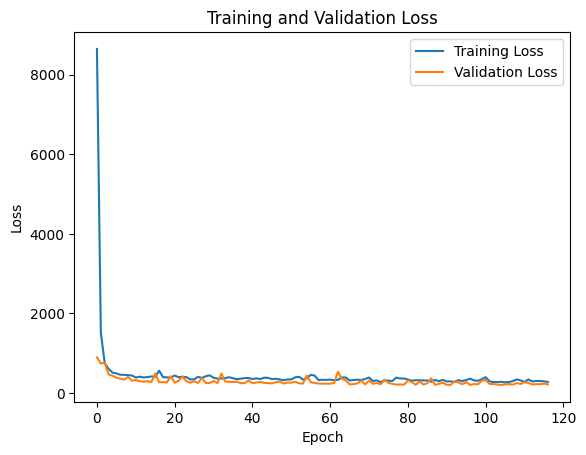

In [29]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [30]:
# Evaluate the model
test_loss, test_mae = model.evaluate(
    {"Transformer_Input": X_test_lstm, "CNN_Input": X_test_cwt},
    {"BP_Output": y_test_lstm}
)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


5/5 [==============================] - 0s 47ms/step - loss: 228.1367 - mse: 228.1367
Test Loss: 228.13665771484375, Test MAE: 228.13665771484375


5/5 [==============================] - 1s 57ms/step


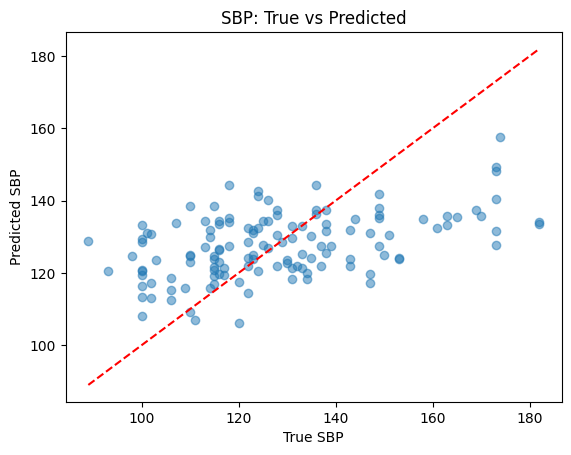

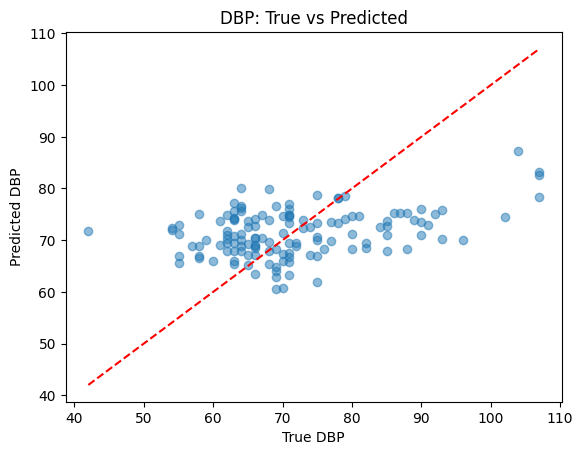

In [31]:
# Predict on test data
predictions = model.predict({"Transformer_Input": X_test_lstm, "CNN_Input": X_test_cwt})

# Compare predictions and true values
predicted_sbp = predictions[:, 0]
predicted_dbp = predictions[:, 1]
true_sbp = y_test_lstm[:, 0]
true_dbp = y_test_lstm[:, 1]

# Scatter plot
plt.scatter(true_sbp, predicted_sbp, alpha=0.5)
plt.plot([min(true_sbp), max(true_sbp)], [min(true_sbp), max(true_sbp)], color='red', linestyle='--')  # Add diagonal
plt.xlabel('True SBP')
plt.ylabel('Predicted SBP')
plt.title('SBP: True vs Predicted')
plt.show()

# Scatter plot for DBP
plt.scatter(true_dbp, predicted_dbp, alpha=0.5)
plt.plot([min(true_dbp), max(true_dbp)], [min(true_dbp), max(true_dbp)], color='red', linestyle='--')  # Add diagonal
plt.xlabel('True DBP')
plt.ylabel('Predicted DBP')
plt.title('DBP: True vs Predicted')
plt.show()



In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate SBP
mae_sbp = mean_absolute_error(true_sbp, predicted_sbp)
mse_sbp = mean_squared_error(true_sbp, predicted_sbp)
print(f"SBP - MAE: {mae_sbp}, MSE: {mse_sbp}")

# Evaluate DBP
mae_dbp = mean_absolute_error(true_dbp, predicted_dbp)
mse_dbp = mean_squared_error(true_dbp, predicted_dbp)
print(f"DBP - MAE: {mae_dbp}, MSE: {mse_dbp}")


SBP - MAE: 14.765975431962447, MSE: 336.07917774754804
DBP - MAE: 8.85304407639937, MSE: 120.19410917036238


In [33]:
predicted_sbp

array([117.29584 , 124.82414 , 137.35686 , 138.62866 , 134.48001 ,
       127.341225, 107.05667 , 121.31343 , 133.63773 , 126.22736 ,
       135.18692 , 119.45291 , 127.29912 , 134.43134 , 127.4291  ,
       109.09809 , 137.99593 , 124.7374  , 130.98187 , 129.87817 ,
       134.33893 , 140.532   , 132.93227 , 144.45195 , 134.87471 ,
       123.775604, 121.29303 , 144.27107 , 121.84541 , 124.25817 ,
       135.477   , 123.58182 , 157.53575 , 134.24309 , 121.84259 ,
       127.68094 , 136.3621  , 128.68678 , 148.27394 , 113.3998  ,
       132.32323 , 133.23465 , 125.06352 , 130.4085  , 134.14973 ,
       118.38334 , 119.99921 , 120.808304, 119.714066, 118.33633 ,
       125.453865, 126.530975, 115.72126 , 131.07596 , 128.6677  ,
       120.60332 , 131.64903 , 115.39532 , 132.39388 , 114.40454 ,
       141.88684 , 127.4764  , 117.45578 , 123.72983 , 112.97266 ,
       108.153076, 127.78583 , 138.59053 , 120.59343 , 131.82423 ,
       133.48589 , 133.71843 , 137.29384 , 124.13843 , 117.018

In [34]:
predicted_dbp

array([67.17761 , 69.65137 , 76.274574, 76.64019 , 74.91621 , 71.03853 ,
       60.718315, 67.974106, 74.539986, 70.50976 , 75.05425 , 67.216576,
       70.370384, 74.71317 , 71.21492 , 61.866405, 76.93223 , 69.51439 ,
       72.81666 , 72.576584, 74.9363  , 78.36655 , 74.157845, 80.1533  ,
       75.167946, 69.443214, 68.23084 , 79.8291  , 68.31963 , 71.07894 ,
       75.290855, 69.199486, 87.27594 , 74.99737 , 68.4672  , 71.09939 ,
       75.892914, 71.98351 , 82.5252  , 65.33975 , 73.78903 , 74.14617 ,
       70.103516, 72.96258 , 74.72227 , 66.6672  , 66.86346 , 67.91778 ,
       67.13268 , 66.56605 , 70.22522 , 70.511406, 65.199905, 73.32621 ,
       71.263145, 68.800735, 72.74265 , 64.7676  , 73.91984 , 64.12474 ,
       78.14962 , 71.38108 , 65.981514, 69.52393 , 63.542824, 63.33388 ,
       70.64329 , 77.22872 , 67.91764 , 73.32773 , 74.10283 , 73.95135 ,
       75.936714, 69.478264, 65.78094 , 73.83782 , 66.992226, 73.88288 ,
       68.4241  , 72.39908 , 67.87265 , 67.3498  , 